## Evaluation of avg and loo model and fusion

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import cortico_cereb_connectivity.run_model as rm
import matplotlib.pyplot as plt

In [9]:
def heatmap_annotate(df_to_plot, ds_order, ax, column=['train_dataset'], row=['eval_dataset'], value=['R_eval'], cmap='inferno', vmin=0, vmax=0.5):
    if 'Fusion' in ds_order:
        ds_order_y = [ds for ds in ds_order if ds!='Fusion']
    else:
        ds_order_y = ds_order
    V = pd.pivot_table(df_to_plot, columns=column, index=row, values=value)
    V = V.reindex(ds_order_y, axis=0)
    V = V.reindex(ds_order, level=1, axis=1)

    sns.heatmap(V.values, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax, 
                xticklabels=V.columns.get_level_values(1).values, 
                yticklabels=V.index.values, square=True, ax=ax)
    if 'Fusion' in ds_order:
        ax.axvline(len(ds_order_y), color='k', linewidth=2)

    return ax

### Simple avg across subjects

In [3]:
method = 'L2reg'
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if eval_ds!=dataset_name]

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-globalSTD"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df], ignore_index=True)

    # Load loo performances
    df = rm.comb_eval(models=[dataset_name+"-loo-globalSTD"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
    df['model'] = dataset_name+"-loo"
    df_all = pd.concat([df_all, df], ignore_index=True)

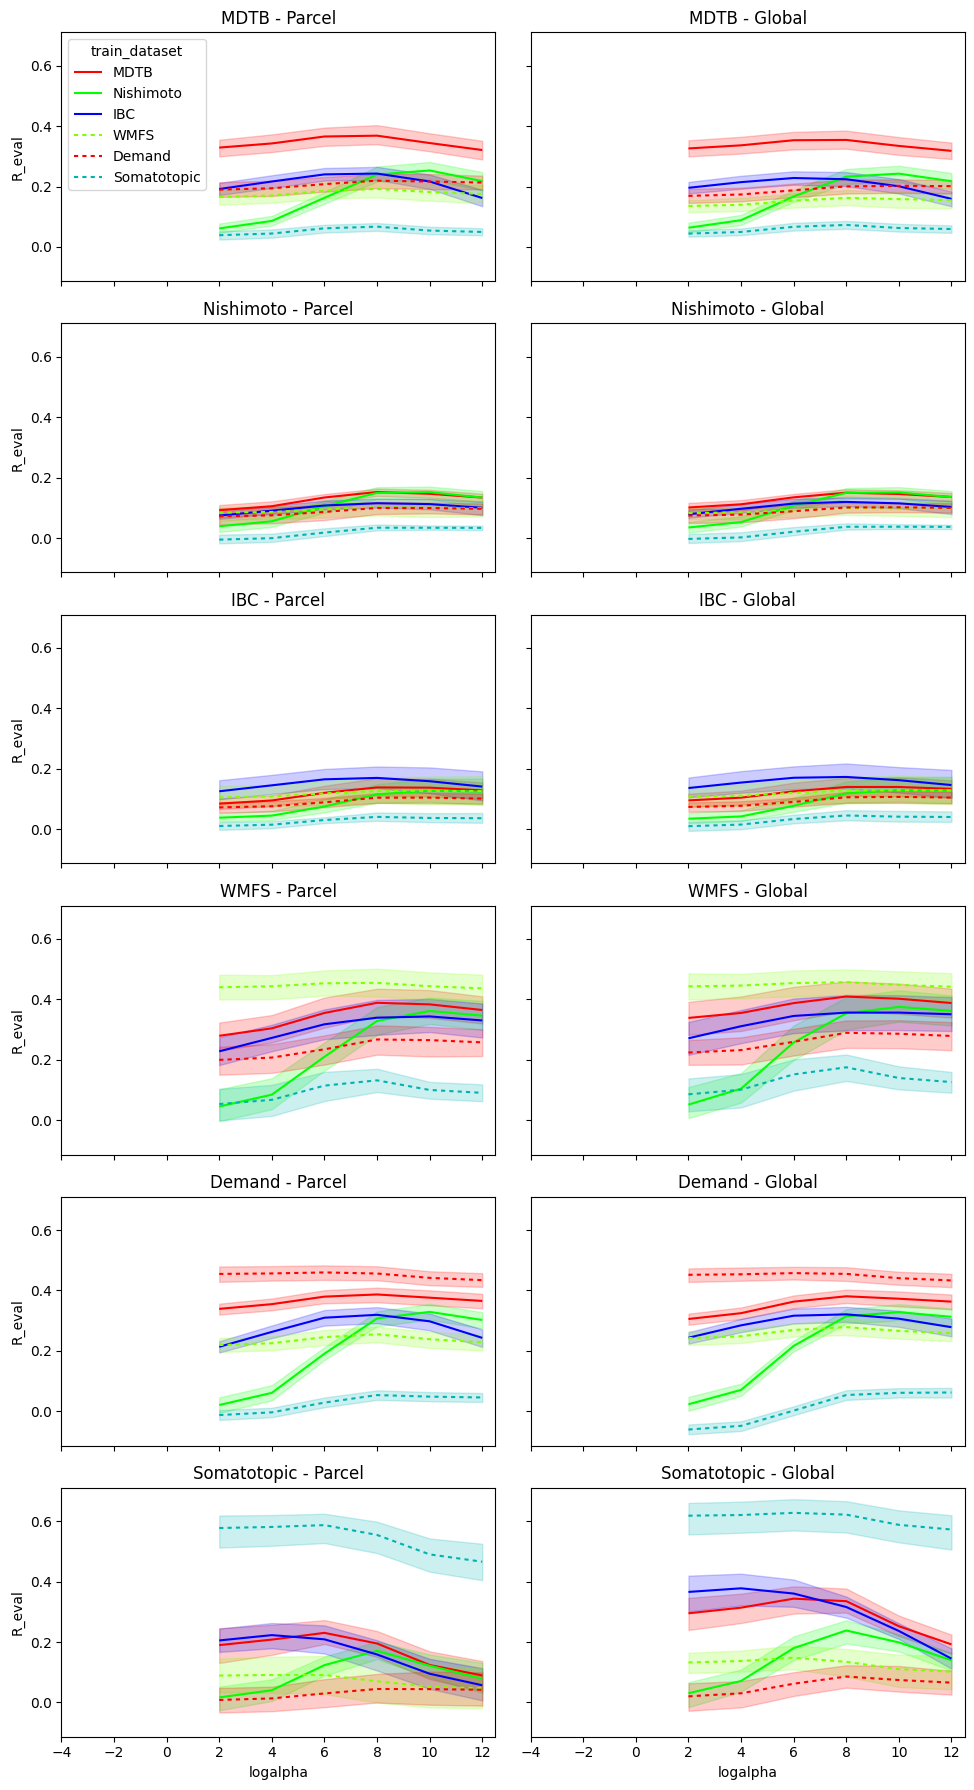

In [4]:
evd=['MDTB','Nishimoto','IBC','WMFS','Demand','Somatotopic']
palette = [[1,0,0],[0,1,0],[0,0,1],[0.5,1,0],[1,0,0],[0,0.7,0.7]]
dashes = [[1,0],[1,0],[1,0],[2,2],[2,2],[2,2]]

df_all_parcel = df_all[df_all.std_cortex=='parcel'].reset_index(drop=True)
df_all_global = df_all[df_all.std_cortex=='global'].reset_index(drop=True)

plt.subplots(6,2,figsize=(10,18), sharey=True, sharex=True)
for i,ed in enumerate(evd):
    ax = plt.subplot(6,2,2*i+1)
    df_to_plot = df_all_parcel[(df_all_parcel.eval_dataset==ed) & ((df_all_parcel.train_dataset!=ed) | (df_all_parcel.model.str.contains('loo')))]
    plt.title(f'{ed} - Parcel')
    if i==0:
        sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', palette=palette, style='train_dataset',
                     dashes=dashes, hue_order=evd, style_order=evd)
    else:
        sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', palette=palette, style='train_dataset',
                     dashes=dashes, hue_order=evd, style_order=evd, legend=None)
    plt.xlim([-4, 12.5])
    plt.subplot(6,2,2*i+2)
    df_to_plot = df_all_global[(df_all_global.eval_dataset==ed) & ((df_all_global.train_dataset!=ed) | (df_all_global.model.str.contains('loo')))]
    plt.title(f'{ed} - Global')
    sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha', hue='train_dataset', palette=palette, style='train_dataset',
                     dashes=dashes, hue_order=evd, style_order=evd, legend=None)
    plt.xlim([-4, 12.5])
plt.tight_layout()

Text(0.5, 1.0, 'Global')

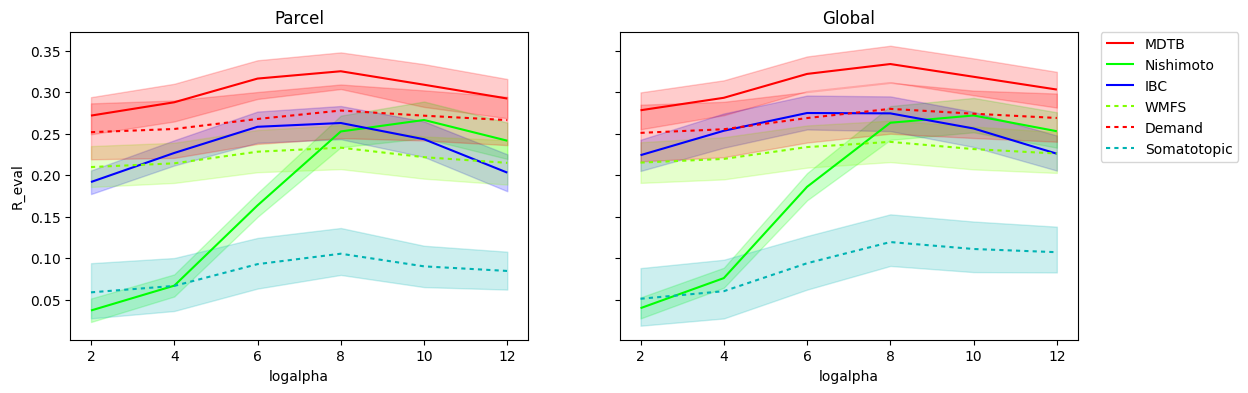

In [5]:
# Plot all evaluations on different datasets
plt.subplots(1,2,figsize=(13,4), sharey=True)

df_to_plot = df_all_parcel[(df_all_parcel.train_dataset!=df_all_parcel.eval_dataset) | (df_all_parcel.model.str.contains('loo'))]
plt.subplot(1,2,1)
sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha',
             hue='train_dataset', style='train_dataset',
             hue_order=evd, style_order=evd,
             palette=palette, dashes=dashes, legend=None)
plt.title('Parcel')

df_to_plot = df_all_global[(df_all_global.train_dataset!=df_all_global.eval_dataset) | (df_all_global.model.str.contains('loo'))]
plt.subplot(1,2,2)
sns.lineplot(data=df_to_plot, y='R_eval', x='logalpha',
             hue='train_dataset', style='train_dataset',
             hue_order=evd, style_order=evd,
             palette=palette, dashes=dashes)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Global')

In [6]:
ds_order = ["Demand", "IBC", "MDTB", "Nishimoto", "Somatotopic", "WMFS"]
for i,df_to_pivot in enumerate([df_all_parcel, df_all_global]):
    A = pd.pivot_table(df_to_pivot,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(ds_order)
    display(A)
    B = np.nan_to_num(A.values)
    ind = B.argmax(axis=1)
    log_a = np.array(A.columns.get_level_values(1)[ind])
    bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
    display(bestla)

    if i==0:
        df_all_parcel['isbest'] = df_all_parcel.logalpha.values == bestla.loc[df_all_parcel.train_dataset].values.flatten()
    else:
        df_all_global['isbest'] = df_all_global.logalpha.values == bestla.loc[df_all_global.train_dataset].values.flatten()

R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
Demand         0.251773  0.255634  0.267703  0.277864  0.271662  0.266340
IBC            0.191712  0.226729  0.258283  0.262845  0.243269  0.203015
MDTB           0.271770  0.287838  0.316403  0.325228  0.308976  0.292345
Nishimoto      0.036820  0.066753  0.163505  0.252656  0.266492  0.241513
Somatotopic    0.058691  0.066444  0.092694  0.105258  0.090023  0.084489
WMFS           0.209744  0.214232  0.228241  0.233099  0.221640  0.214800

,best_logalpha
train_dataset,
Demand,8.0
IBC,8.0
MDTB,8.0
Nishimoto,10.0
Somatotopic,8.0
WMFS,8.0


R_eval                                                  
logalpha           2.0       4.0       6.0       8.0       10.0      12.0
train_dataset                                                            
Demand         0.250956  0.255311  0.268805  0.279885  0.274052  0.268891
IBC            0.224070  0.253482  0.274896  0.274455  0.256242  0.225810
MDTB           0.278209  0.293232  0.322021  0.333936  0.318577  0.303162
Nishimoto      0.039639  0.075857  0.185906  0.263147  0.271920  0.252916
Somatotopic    0.050969  0.060070  0.093793  0.119323  0.110956  0.107090
WMFS           0.215094  0.219541  0.233817  0.240095  0.231406  0.226035

,best_logalpha
train_dataset,
Demand,8.0
IBC,6.0
MDTB,8.0
Nishimoto,10.0
Somatotopic,8.0
WMFS,8.0


### Summary Graph of all models evaluated at their best hyperparameter. 

In [7]:
# Get cross-validated single training sets models 
d_parcel = df_all_parcel[((df_all_parcel.train_dataset!=df_all_parcel.eval_dataset) | (df_all_parcel.model.str.contains('loo'))) & df_all_parcel.isbest].reset_index(drop=True)
d_global = df_all_global[((df_all_global.train_dataset!=df_all_global.eval_dataset) | (df_all_global.model.str.contains('loo'))) & df_all_global.isbest].reset_index(drop=True)
d_jorn = pd.read_csv('../data/Nettekoven2024_model_evaluations.tsv',sep='\t')
d_jorn = d_jorn[(d_jorn['train_dataset']!='HCP') | (d_jorn['train_dataset']!='Fusion')].reset_index(drop=True)

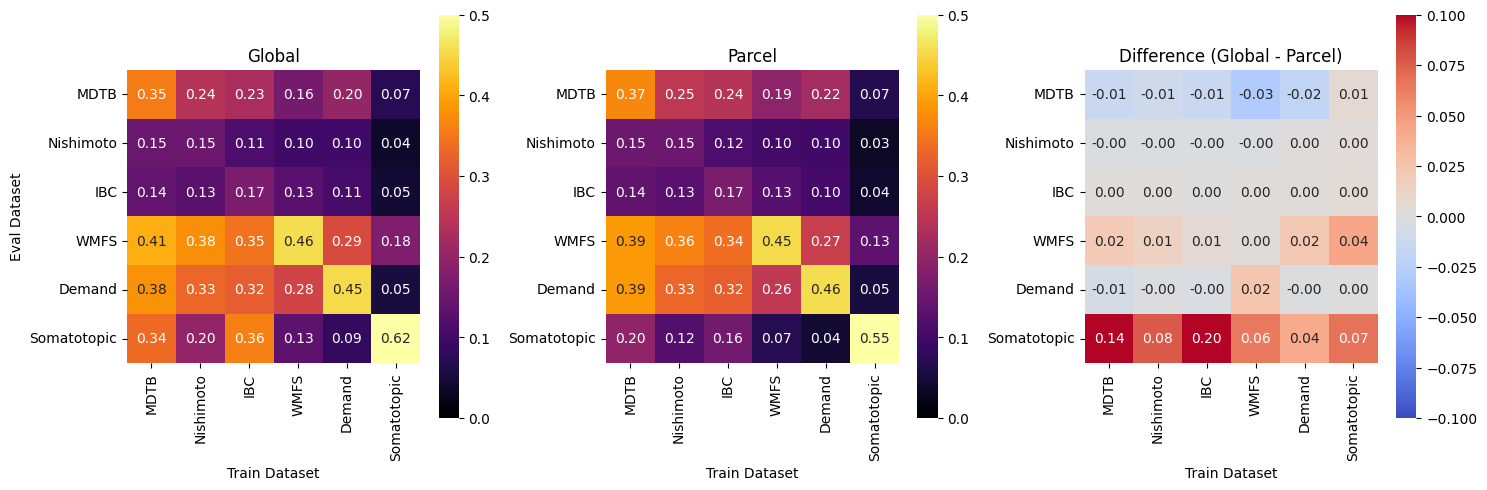

In [11]:
ds_order = ['MDTB', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic']
fig, axes = plt.subplots(1,3,figsize=(15,5))

ax = heatmap_annotate(d_global, ds_order, ax=axes[0])
ax.set_title('Global')
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')

ax = heatmap_annotate(d_parcel, ds_order, ax=axes[1])
ax.set_title('Parcel')
ax.set_xlabel('Train Dataset')

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(d_parcel[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   d_global[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_parcel', '_global'))

df_diff['R_eval_diff'] = df_diff['R_eval_global'] - df_diff['R_eval_parcel']
ax = heatmap_annotate(df_diff, ds_order, ax=axes[2], value=['R_eval_diff'], cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Global - Parcel)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()

In [53]:
method = 'L2reg'
dataset_list = ["MDTB", "WMFS", "Demand", "Somatotopic", "Nishimoto", "IBC"]
df_all = pd.DataFrame()
for dataset_name in dataset_list:
    eval_data = [eval_ds for eval_ds in dataset_list if ((eval_ds!=dataset_name) & (eval_ds!='MDTB'))]

    # Load avg performances
    df = rm.comb_eval(models=[dataset_name+"-avg-globalSTD"],methods=[method],eval_data=eval_data,cerebellum='MNISymC3')
    df['model'] = dataset_name+"-avg"
    df_all = pd.concat([df_all, df], ignore_index=True)

    if dataset_name == 'MDTB':
        # Load loo performances
        df = rm.comb_eval(models=[dataset_name+"-loo"],methods=[method],eval_data=['MDTB'],cerebellum='MNISymC3')
        df['model'] = dataset_name+"-loo"
        df_all = pd.concat([df_all, df], ignore_index=True)
    else:
        # Load loo performances
        df = rm.comb_eval(models=[dataset_name+"-loo-globalSTD"],methods=[method],eval_data=[dataset_name if dataset_name!='Language' else 'Languagelocalizer_cond'],cerebellum='MNISymC3')
        df['model'] = dataset_name+"-loo"
        df_all = pd.concat([df_all, df], ignore_index=True)
        
        # Load avg performances
        df = rm.comb_eval(models=[dataset_name+"-avg"],methods=[method],eval_data=['MDTB'],cerebellum='MNISymC3')
        df['model'] = dataset_name+"-avg"
        df_all = pd.concat([df_all, df], ignore_index=True)

dfuse = rm.comb_eval(models=['Fus06-bestSTD-avg'],methods=[method],eval_data=dataset_list,cerebellum='MNISymC3')
dfuse.train_dataset = 'Fusion'
df_all = pd.concat([df_all,dfuse]).reset_index(drop=True)

d_jorn = pd.read_csv('../data/Nettekoven2024_model_evaluations.tsv',sep='\t')
d_jorn = d_jorn[d_jorn['train_dataset']!='HCP'].reset_index(drop=True)

In [54]:
ds_order = ["Demand", "IBC", "MDTB", "Nishimoto", "Somatotopic", "WMFS", "Fusion"]
A = pd.pivot_table(df_all,index=['train_dataset'],columns=['logalpha'],values=['R_eval'],aggfunc='mean').reindex(ds_order)
display(A)
B = np.nan_to_num(A.values)
ind = B.argmax(axis=1)
log_a = np.array(A.columns.get_level_values(1)[ind])
bestla = pd.DataFrame(log_a,index=A.index,columns=['best_logalpha'])
bestla = bestla.reindex([*dataset_list, 'Fusion'])
display(bestla)

df_all['isbest'] = df_all.logalpha.values == bestla.loc[df_all.train_dataset].values.flatten()

R_eval                                                    \
logalpha            2.0       4.0       6.0       8.0      10.0      12.0   
train_dataset                                                               
Demand         0.255751  0.260089  0.273559  0.284301  0.277352  0.271676   
IBC            0.223141  0.253980  0.277684  0.278835  0.259923  0.226458   
MDTB           0.278875  0.294684  0.324896  0.337214  0.320803  0.303792   
Nishimoto      0.039092  0.075256  0.184839  0.264758  0.274384  0.252967   
Somatotopic    0.049726  0.058843  0.092616  0.118001  0.108970  0.104845   
WMFS           0.222041  0.226678  0.241417  0.246998  0.236838  0.230876   
Fusion              NaN       NaN       NaN       NaN       NaN       NaN   

                                   
logalpha      [8, 8, 8, 8, 10, 8]  
train_dataset                      
Demand                        NaN  
IBC                           NaN  
MDTB                          NaN  
Nishimoto                     NaN  
Somatotopic                   NaN  
WMFS                          NaN  
Fusion                   0.362895

,best_logalpha
train_dataset,
MDTB,8.0
WMFS,8.0
Demand,8.0
Somatotopic,8.0
Nishimoto,10.0
IBC,8.0
Fusion,"[8, 8, 8, 8, 10, 8]"


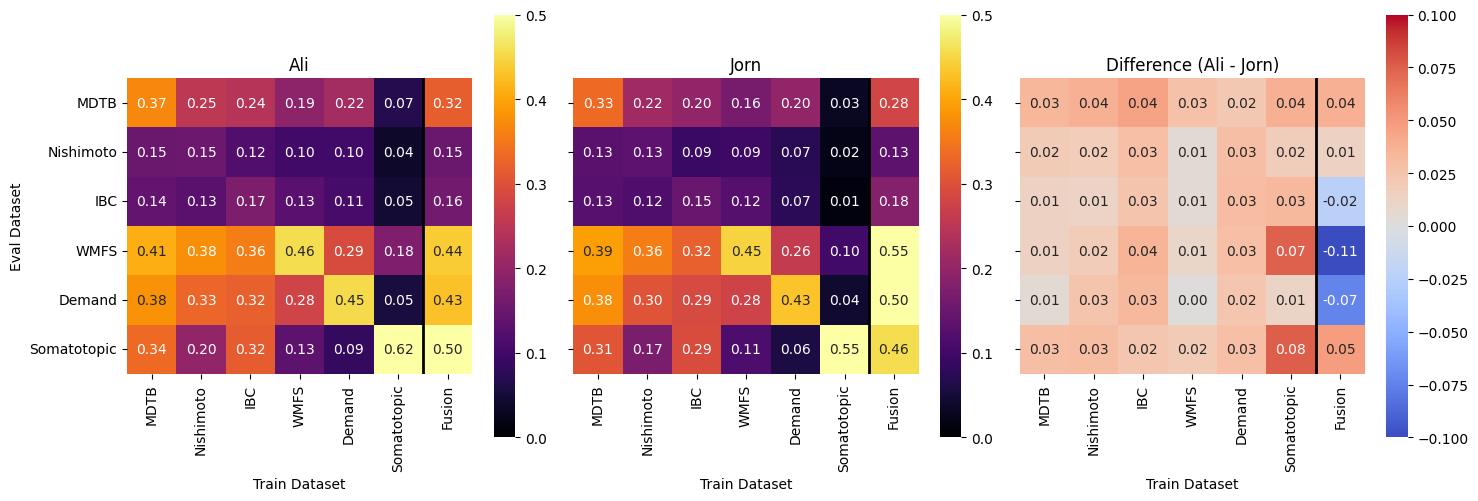

In [55]:
ds_order = ['MDTB', 'Nishimoto', 'IBC', 'WMFS', 'Demand', 'Somatotopic', 'Fusion']
df_Ali = df_all[((df_all.train_dataset!=df_all.eval_dataset) | (df_all.model.str.contains('loo'))) & df_all.isbest].reset_index(drop=True)
fig, axes = plt.subplots(1,3,figsize=(15,5), sharey=True, sharex=True)

ax = heatmap_annotate(df_Ali, ds_order, ax=axes[0])
ax.set_title('Ali')
ax.set_xlabel('Train Dataset')
ax.set_ylabel('Eval Dataset')

ax = heatmap_annotate(d_jorn, ds_order, ax=axes[1])
ax.set_title('Jorn')
ax.set_xlabel('Train Dataset')

# Calculate the difference in 'R_eval' for the same group of (train_dataset, eval_dataset, eval_subj)
df_diff = pd.merge(df_Ali[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   d_jorn[['train_dataset', 'eval_dataset', 'eval_subj', 'R_eval']],
                   on=['train_dataset', 'eval_dataset', 'eval_subj'],
                   suffixes=('_Ali', '_Jorn'))

df_diff['R_eval_diff'] = df_diff['R_eval_Ali'] - df_diff['R_eval_Jorn']
ax = heatmap_annotate(df_diff, ds_order, ax=axes[2], value=['R_eval_diff'], cmap='coolwarm', vmin=-0.1, vmax=0.1)
ax.set_title('Difference (Ali - Jorn)')
ax.set_xlabel('Train Dataset')

plt.tight_layout()

(-0.2, 0.2)

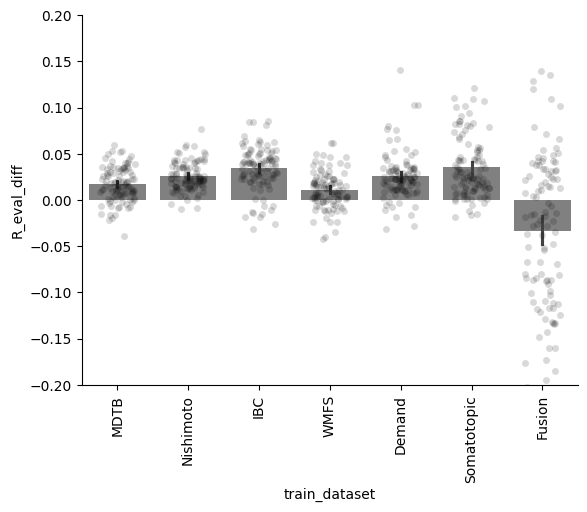

In [52]:
sns.barplot(data=df_diff,x='train_dataset',y='R_eval_diff',order=ds_order,color=[0.5,0.5,0.5])
sns.stripplot(data=df_diff,x='train_dataset',y='R_eval_diff',color=[0,0,0], alpha=0.15,jitter=0.25)
ax=plt.gca()
ax.set_xticks(np.arange(len(ds_order)))
ax.set_xticklabels(ds_order, rotation=90)
# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-0.2, 0.2])